# Read Dataset and import libraries

In [24]:
! git clone https://github.com/Ironarrow98/Zhang_Chenxi_BS6207_Final

fatal: destination path 'Zhang_Chenxi_BS6207_Final' already exists and is not an empty directory.


In [25]:
! pip install sparse

In [26]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import random
import pandas as pd
from tqdm import tqdm, trange
import sparse
from sparse import COO
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D,Flatten,Dense, Dropout, BatchNormalization, Add, AveragePooling3D, Activation, GaussianNoise, Lambda
from tensorflow.keras import optimizers, losses, regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_curve, auc, classification_report

In [27]:
# Reads a up to spec pdb file and return a tuple of the
# atoms' x, y, z and atomtype
def read_pdb(filename):
  with open(filename, 'r') as file:
    strline_L = file.readlines()
  atom_list = []
  for strline in strline_L:
    # removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
    stripped_line = strline.strip()

    line_length = len(stripped_line)
    # print("Line length:{}".format(line_length))
    if line_length < 78:
      print("ERROR: line length is different. Expected>=78, current={}".format(line_length))
        
    atom_list.append((
        stripped_line[30:38].strip(),
        stripped_line[38:46].strip(),
        stripped_line[46:54].strip(),
        'h' if stripped_line[76:78].strip() == 'C' else 'p'
        ))
        
  return np.array(atom_list, order='F')

In [28]:
raw_training_data = {
    'pro': [],
    'lig': []
}
for i in trange(3000):
  raw_training_data['pro'].append(
      read_pdb('Zhang_Chenxi_BS6207_Final/training_data/{:04d}_pro_cg.pdb'.format(i + 1)))
  raw_training_data['lig'].append(
      read_pdb("Zhang_Chenxi_BS6207_Final/training_data/{:04d}_lig_cg.pdb".format(i + 1)))

n = int(len(raw_training_data['pro']) * 0.77)
raw_training_train_data = {
    'pro': raw_training_data['pro'][:n],
    'lig': raw_training_data['lig'][:n]
}
raw_training_test_data = {
    'pro': raw_training_data['pro'][n:],
    'lig': raw_training_data['lig'][n:]
}

100%|██████████| 3000/3000 [00:10<00:00, 292.27it/s]


# Data Pre-processing

In [29]:
# Returns a sparse matrix representation of the voxel
def voxelize(pdb_inputs, max_dist, grid_resolution):
  
  def featurize(atom_type):
    feat = [0, 128]
    # Change to ligand
    if atom_type[1] == 'l':
      feat[0] = 1
    # change to polar
    if atom_type[0] == 'p':
      feat[1] = 256
    return feat
    
  max_dist = float(max_dist)
  grid_resolution = float(grid_resolution)
  box_size = np.ceil(2 * max_dist / grid_resolution)

  # merge protein and ligand
  pro_atomtypes = pdb_inputs[0]
  lig_atomtypes = pdb_inputs[1]
  pro_atomtype = np.c_[pro_atomtypes, np.full(pro_atomtypes.shape[0], 'p')]
  lig_atomtype = np.c_[lig_atomtypes, np.full(lig_atomtypes.shape[0], 'l')]
  all_atoms = np.r_[pro_atomtype, lig_atomtype]

  # center all atoms around the mean of the ligand
  cord_map = all_atoms[:, :3].astype(float)
  cord_map = cord_map - np.mean(lig_atomtype[:, :3].astype(float), axis = 0)

  # add feature list to identify the atom h/p and pro/lig
  feature_list = np.asarray([featurize(atom_type) for atom_type in all_atoms[:, -2:]])  
  atom_map = np.c_[cord_map, feature_list]

  # map all atoms to the nearest grid point
  atom_map = np.c_[cord_map, feature_list]
  atom_map[:, :3] = (atom_map[:, :3] + max_dist) / grid_resolution
  atom_map[:, :3] = atom_map[:, :3].round()
  atom_map = atom_map.astype(int)

  # remove atoms outside the box
  in_box = ((atom_map[:, :3] >= 0) & (atom_map[:, :3] < box_size)).all(axis = 1)
  atom_map = atom_map[in_box]

  # transpose the matrix
  features_list = np.squeeze(atom_map[:, -1:])
  atom_map = atom_map[:, :4].T
    
  # create the sparse matrix
  result = COO(atom_map, features_list, shape = (int(box_size), int(box_size), int(box_size), 2))
  result.sum()
  result = result.reshape((1, int(box_size), int(box_size), int(box_size), 2))
  
  return result

In [30]:
# Returns a tuple containg the training data and corresponding labels
# ratio specifies the number of negative training examples generated
# per positive training example
def generate_training_data(raw_data, max_dist, grid_resolution):
  n = len(raw_data['pro'])
  X = []
  y = []
  pro_name = []
  lig_name = []
  for i in tqdm(range(n)):

    # Generate Positive Pair
    pos_pair = voxelize((raw_data['pro'][i], 
                         raw_data['lig'][i]), 
                        max_dist, 
                        grid_resolution)
    X.append(pos_pair)
    y.append(1)
    pro_name.append(i)
    lig_name.append(i)

    # Generate Negative Pair
    pn = random.choice(range(1, n))
    ln = pn
    while ln == pn:
      ln = random.choice(range(1, n))
    neg_pair = voxelize((raw_data['pro'][pn], 
                         raw_data['lig'][ln]), 
                        max_dist, 
                        grid_resolution)
    X.append(neg_pair)
    y.append(0)
    pro_name.append(pn)
    lig_name.append(ln)

  return sparse.concatenate(X), np.asarray(y), pro_name, lig_name

In [31]:
X, y, train_pro, train_lig = generate_training_data(raw_training_data, max_dist = 40, grid_resolution = 4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size = 0.33, random_state = 42)  

100%|██████████| 3000/3000 [00:36<00:00, 81.19it/s]


In [32]:
train_X = train_X.todense()
val_X = val_X.todense()
X_test = X_test.todense()

# CNN Model

## Model Construction

In [33]:
def make_CNN(input_shape):

  inputs = Input(shape = input_shape)
  x = inputs
  x = Conv3D(filters = 32,
             kernel_size = 3,
             strides = 1,
             padding = 'same',
             kernel_initializer = 'he_normal',
             activation="relu")(x)     
  x = BatchNormalization()(x)
  x = MaxPooling3D(pool_size = 2)(x)

  x = Conv3D(filters = 64,
             kernel_size = 3,
             strides = 1,
             padding = 'same',
             kernel_initializer = 'he_normal',
             activation = "relu")(x)     
  x = BatchNormalization()(x)
  x = MaxPooling3D(pool_size = 2)(x)

  x = Conv3D(filters = 128,
             kernel_size = 3,
             strides = 1,
             padding = 'same',
             kernel_initializer = 'he_normal',
             activation = "relu")(x)     
  x = BatchNormalization()(x)
  x = MaxPooling3D(pool_size = 2)(x)

  x = Conv3D(filters = 256,
             kernel_size = 3,
             strides = 1,
             padding = 'same',
             kernel_initializer = 'he_normal',
             activation = "relu")(x)     
  x = BatchNormalization()(x)
  x = MaxPooling3D(pool_size = 2)(x)

  x = Flatten()(x)
  x = Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(x)
  x = Dropout(0.5)(x)
  outputs = Dense(1, activation = 'sigmoid', kernel_initializer = 'he_normal')(x)

  return Model(inputs = inputs, outputs = outputs)

## Optimizers

In [34]:
model1 = make_CNN(input_shape=(20, 20, 20, 2))
model2 = make_CNN(input_shape=(20, 20, 20, 2))
model3 = make_CNN(input_shape=(20, 20, 20, 2))
model1.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 20, 20, 20, 2)]   0         
                                                                 
 conv3d_40 (Conv3D)          (None, 20, 20, 20, 32)    1760      
                                                                 
 batch_normalization_40 (Bat  (None, 20, 20, 20, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 10, 10, 10, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 10, 10, 10, 64)    55360     
                                                                 
 batch_normalization_41 (Bat  (None, 10, 10, 10, 64)   256

In [35]:
model1.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer='Adam'
)

model2.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer='SGD'
)

model3.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer='RMSprop'
)

# create a callback that will save the best model while training
save_best_model1 = ModelCheckpoint('best_model1.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)
save_best_model2 = ModelCheckpoint('best_model2.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)
save_best_model3 = ModelCheckpoint('best_model3.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)

history1 = model1.fit(train_X, train_y, batch_size = 64, epochs = 20, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model1])
history2 = model2.fit(train_X, train_y, batch_size = 64, epochs = 20, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model2])
history3 = model3.fit(train_X, train_y, batch_size = 64, epochs = 20, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model3])

Epoch 1/20
43/43 [==============================] - ETA: 0s - loss: 0.3485 - acc: 0.8901
Epoch 1: val_acc improved from -inf to 0.75283, saving model to best_model1.h5
43/43 [==============================] - 108s 2s/step - loss: 0.3485 - acc: 0.8901 - val_loss: 3.4052 - val_acc: 0.7528
Epoch 2/20
43/43 [==============================] - ETA: 0s - loss: 0.2119 - acc: 0.9272
Epoch 2: val_acc improved from 0.75283 to 0.92540, saving model to best_model1.h5
43/43 [==============================] - 107s 2s/step - loss: 0.2119 - acc: 0.9272 - val_loss: 0.2780 - val_acc: 0.9254
Epoch 3/20
43/43 [==============================] - ETA: 0s - loss: 0.1935 - acc: 0.9309
Epoch 3: val_acc improved from 0.92540 to 0.92992, saving model to best_model1.h5
43/43 [==============================] - 108s 3s/step - loss: 0.1935 - acc: 0.9309 - val_loss: 0.2283 - val_acc: 0.9299
Epoch 4/20
43/43 [==============================] - ETA: 0s - loss: 0.1750 - acc: 0.9421
Epoch 4: val_acc did not improve from 0.9

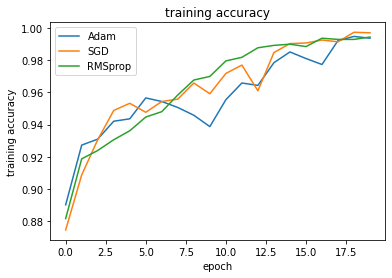

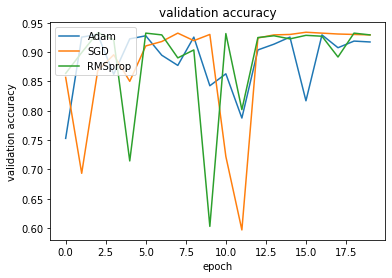

In [36]:
# Plot training accuracy
plt.plot(history1.history['acc'])
plt.plot(history2.history['acc'])
plt.plot(history3.history['acc'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Adam', 'SGD', 'RMSprop'], loc = 'upper left')
plt.show()

# Plot validation accuracy
plt.plot(history1.history['val_acc'])
plt.plot(history2.history['val_acc'])
plt.plot(history3.history['val_acc'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Adam', 'SGD', 'RMSprop'], loc = 'upper left')
plt.show()

## Batch Size

In [16]:
model4 = make_CNN(input_shape=(20, 20, 20, 2))
model5 = make_CNN(input_shape=(20, 20, 20, 2))
model6 = make_CNN(input_shape=(20, 20, 20, 2))
model7 = make_CNN(input_shape=(20, 20, 20, 2))

model4.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer='Adam'
)

model5.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer='Adam'
)

model6.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer='Adam'
)

model7.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer='Adam'
)

# create a callback that will save the best model while training
save_best_model4 = ModelCheckpoint('best_model4.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)
save_best_model5 = ModelCheckpoint('best_model5.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)
save_best_model6 = ModelCheckpoint('best_model6.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)
save_best_model7 = ModelCheckpoint('best_model7.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)

history4 = model4.fit(train_X, train_y, batch_size = 32, epochs = 10, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model4])
history5 = model5.fit(train_X, train_y, batch_size = 64, epochs = 10, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model5])
history6 = model6.fit(train_X, train_y, batch_size = 128, epochs = 10, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model6])
history7 = model7.fit(train_X, train_y, batch_size = 256, epochs = 10, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model7])

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.3441 - acc: 0.8983
Epoch 1: val_acc improved from -inf to 0.72344, saving model to best_model4.h5
85/85 [==============================] - 110s 1s/step - loss: 0.3441 - acc: 0.8983 - val_loss: 1.0462 - val_acc: 0.7234
Epoch 2/10
85/85 [==============================] - ETA: 0s - loss: 0.2056 - acc: 0.9320
Epoch 2: val_acc improved from 0.72344 to 0.90957, saving model to best_model4.h5
85/85 [==============================] - 110s 1s/step - loss: 0.2056 - acc: 0.9320 - val_loss: 0.2432 - val_acc: 0.9096
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.1760 - acc: 0.9424
Epoch 3: val_acc improved from 0.90957 to 0.92690, saving model to best_model4.h5
85/85 [==============================] - 110s 1s/step - loss: 0.1760 - acc: 0.9424 - val_loss: 0.2125 - val_acc: 0.9269
Epoch 4/10
85/85 [==============================] - ETA: 0s - loss: 0.1659 - acc: 0.9491
Epoch 4: val_acc improved from 0.92690 to

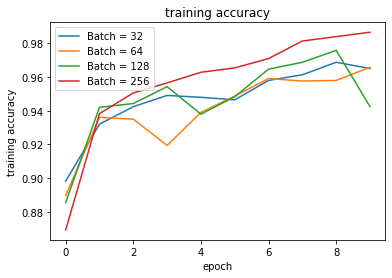

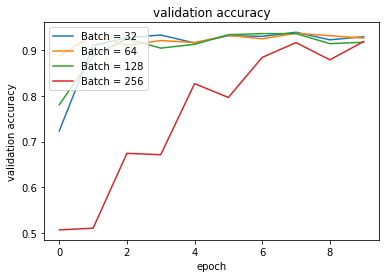

In [17]:
# Plot training accuracy
plt.plot(history4.history['acc'])
plt.plot(history5.history['acc'])
plt.plot(history6.history['acc'])
plt.plot(history7.history['acc'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Batch = 32', 'Batch = 64', 'Batch = 128', 'Batch = 256'], loc = 'upper left')
plt.show()

# Plot validation accuracy
plt.plot(history4.history['val_acc'])
plt.plot(history5.history['val_acc'])
plt.plot(history6.history['val_acc'])
plt.plot(history7.history['val_acc'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Batch = 32', 'Batch = 64', 'Batch = 128', 'Batch = 256'], loc = 'upper left')
plt.show()

## Learning Rate

In [18]:
model8 = make_CNN(input_shape=(20, 20, 20, 2))
model9 = make_CNN(input_shape=(20, 20, 20, 2))
model10 = make_CNN(input_shape=(20, 20, 20, 2))

model8.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer=Adam(learning_rate = 0.01)
)

model9.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer=Adam(learning_rate = 0.001)
)

model10.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer=Adam(learning_rate = 0.0001)
)

# create a callback that will save the best model while training
save_best_model8 = ModelCheckpoint('best_model8.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)
save_best_model9 = ModelCheckpoint('best_model9.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)
save_best_model10 = ModelCheckpoint('best_model10.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)

history8 = model8.fit(train_X, train_y, batch_size = 32, epochs = 10, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model8])
history9 = model9.fit(train_X, train_y, batch_size = 32, epochs = 10, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model9])
history10 = model10.fit(train_X, train_y, batch_size = 32, epochs = 10, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model10])

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.4504 - acc: 0.8879
Epoch 1: val_acc improved from -inf to 0.69480, saving model to best_model8.h5
85/85 [==============================] - 114s 1s/step - loss: 0.4504 - acc: 0.8879 - val_loss: 1.7559 - val_acc: 0.6948
Epoch 2/10
85/85 [==============================] - ETA: 0s - loss: 0.2286 - acc: 0.9291
Epoch 2: val_acc improved from 0.69480 to 0.91937, saving model to best_model8.h5
85/85 [==============================] - 112s 1s/step - loss: 0.2286 - acc: 0.9291 - val_loss: 0.2364 - val_acc: 0.9194
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.2056 - acc: 0.9369
Epoch 3: val_acc improved from 0.91937 to 0.92615, saving model to best_model8.h5
85/85 [==============================] - 112s 1s/step - loss: 0.2056 - acc: 0.9369 - val_loss: 0.2144 - val_acc: 0.9261
Epoch 4/10
85/85 [==============================] - ETA: 0s - loss: 0.1870 - acc: 0.9424
Epoch 4: val_acc improved from 0.92615 to

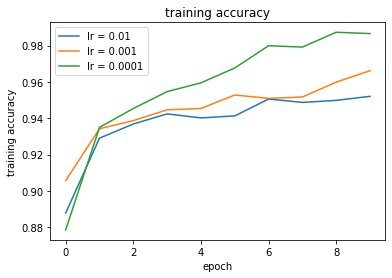

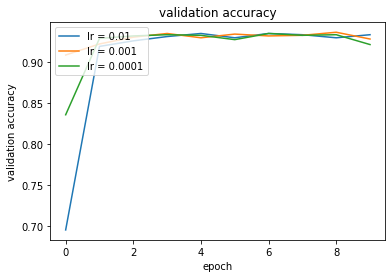

In [19]:
# Plot training accuracy
plt.plot(history8.history['acc'])
plt.plot(history9.history['acc'])
plt.plot(history10.history['acc'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['lr = 0.01', 'lr = 0.001', 'lr = 0.0001'], loc = 'upper left')
plt.show()

# Plot validation accuracy
plt.plot(history8.history['val_acc'])
plt.plot(history9.history['val_acc'])
plt.plot(history10.history['val_acc'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['lr = 0.01', 'lr = 0.001', 'lr = 0.0001'], loc = 'upper left')
plt.show()

## Best Model Validation

In [37]:
best_model = load_model("best_model10.h5")
y_pred = best_model.predict(X_test)
y_pred

array([[9.9908090e-01],
       [4.0474534e-04],
       [2.9971781e-01],
       ...,
       [1.6009808e-04],
       [3.6738013e-05],
       [4.2405354e-06]], dtype=float32)

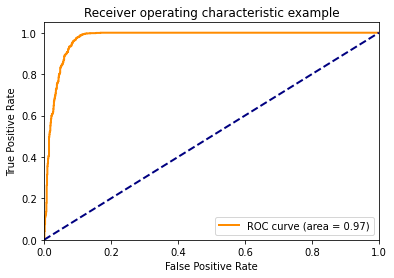

In [38]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [39]:
y_pred = np.piecewise(y_pred, [y_pred < 0.5, y_pred >= 0.5], [0., 1.]).flatten()
y_pred

array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [40]:
a = confusion_matrix(y_test, y_pred)
print(a)

[[923  96]
 [ 31 930]]


In [41]:
a = classification_report(y_test, y_pred, target_names=['Neg Pair', 'Pos Pair'])
print(a)

              precision    recall  f1-score   support

    Neg Pair       0.97      0.91      0.94      1019
    Pos Pair       0.91      0.97      0.94       961

    accuracy                           0.94      1980
   macro avg       0.94      0.94      0.94      1980
weighted avg       0.94      0.94      0.94      1980

